In [1]:
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import soa_jens as SOA
from scipy.integrate import solve_ivp
import jens_plotting as SOAplt
import time

# Computation test med egen RK4 + KE check

In [6]:

def N_body_pendulum(n):
    #setting up link
    m = 200
    l_hinge = np.array([0,0,0.5])
    link = SOA.SimpleLink(m, l_hinge)
    link.set_hingemap("spherical")

    #RBT is constant
    RBT = SOA.RBT(l_hinge)


    #initial config
    state0 = initial_config(n)

    def odefun(t, state, n, link):
        #solve_ivp passes state as np.array. It is unpacked, and then passed to ATBI as a a list of form state = [theta,beta].

        #unpacking state
        theta = state[:4*n]
        beta = state[4*n:]

        #normalizing quartenions
        SOA.normalize_quaternions(theta)
        
        #calculating theta_dot based on the derrivmap function
        theta_dot = np.zeros(len(theta))
        for i in range(n):
            idxq = 4*i #these indexes assume that we ONLY have spherical joints
            idxw = 3*i
            theta_dot[idxq:idxq+4] = SOA.derrivmap(theta[idxq:idxq+4],beta[idxw:idxw+3],"spherical")
            
        #Calculationg of generalized accelerations (beta_dot) - this requires ATBI. 
        tau_vec = np.zeros_like(beta) #no external torques

        A, V, beta_dot_list = ATBIalg(state, tau_vec, n, link, RBT)


        beta_dot = np.concatenate([b.flatten() for b in beta_dot_list[1:n+1]])

        state_dot = np.concatenate([theta_dot, beta_dot.flatten()])

        return state_dot

    def ATBIalg(state, tau_vec, n, link, RBT):

        #unpacking state

        theta_vec = state[:4*n]
        beta_vec  = state[4*n:]

        theta = [None]*(n+2)
        beta  = [None]*(n+2)
        tau   = [None]*(n+2)

        # boundary conditions - det kan diskuteres om man behøver i begge ender for dem alle, det gør man vidst nok ikke
        theta[0]   = np.zeros(4)
        theta[n+1] = np.zeros(4)

        beta[0]    = np.zeros(3)
        beta[n+1]  = np.zeros(3)

        tau[0]     = np.zeros(3)
        tau[n+1]   = np.zeros(3)

        #unpacking interior (IDK OM VI SKAL PASSE DOM EN FUCKING LISTE JEG FØLGER MIT RETARD MATLAB)
        for i in range(1, n+1):

            idxq = 4*(i-1)
            idxw = 3*(i-1)

            theta[i] = theta_vec[idxq:idxq+4]
            beta[i]  = beta_vec[idxw:idxw+3]
            tau[i]   = tau_vec[3*(i-1):3*i]

        # Introducing damping (link closest to ground):
        #tau[n] = -1*beta[n]

        #storage
        P_plus = [None]*(n+2)
        xi_plus = [None]*(n+2)
        nu = [None]*(n+2)
        A = [None]*(n+2)
        V = [None]*(n+2)
        G = [None]*(n+2)
        beta_dot = [None]*(n+2)
        tau_bar = [None]*(n+2)
        agothic = [None]*(n+2)
        bgothic = [None]*(n+2)
        
        #gravity and storage of gravity
        g = [None]*(n+2)
        g[n+1] = np.array([0,0,0,0,0,0*9.81])
        g_f = [None]*(n+2)
        g_f[n+1] = np.array([0,0,0,0,0,-9.81]) #to implement as force

        #boundary conditions on spatial operator quantities
        P_plus[0] = np.zeros((6,6))
        xi_plus[0] = np.zeros((6,))
        tau_bar[0] = P_plus[0]
        A[n+1] = np.array([0, 0, 0, 0, 0, 0])
        V[n+1] = np.zeros((6,))

        #kinematics scatter

        for k in range(n,0,-1):
            #rotation matrices
            pRc = SOA.spatialrotfromquat(theta[k]) #vurder det her
            cRp = pRc.T #from parent to child -> this is the direction we are going right now

            #rotating gravity such that we have that in frame aswell
            g[k] = cRp@g[k+1]
            g_f[k] = cRp@g_f[k+1]

            #hinge contribtuion
            delta_V = link.H.T @ beta[k]

            #spatial velocity
            V[k] = cRp @ RBT.T @ V[k+1] + delta_V

            #coriolois acc
            agothic[k] = SOA.spatialskewtilde(V[k]) @ link.H.T @ beta[k]

            #gyroscopic term
            bgothic[k] = SOA.spatialskewbar(V[k]) @ link.M @ V[k]

        #ATBI gather KOM I GANG
        for k in range(1,n+1): #n+1 fordi den ikke medtager n+1. Det så mærkeligt.

            #rotations
            pRc = SOA.spatialrotfromquat(theta[k-1])
            cRp = pRc.T 

            #gravity force
            f_g = link.M@g_f[k]

            P = RBT @ pRc @ P_plus[k-1] @ cRp@RBT.T + link.M
            D = link.H @ P @ link.H.T
            G[k] = np.linalg.solve(D, link.H @ P).T #P @ link.H.T @ np.linalg.inv(D)
            tau_bar[k] = np.eye(6) - G[k] @ link.H
            P_plus[k] = tau_bar[k] @ P
            xi = RBT @ pRc @ xi_plus[k-1] + P @ agothic[k] + bgothic[k] - SOA.RBT(link.l_com)@f_g
            eps = tau[k] - link.H@xi
            nu[k] = np.linalg.solve(D, eps) #= np.linalg.inv(D)@eps
            xi_plus[k] = xi + G[k]@eps

        #ATBI scatter
        for k in range(n,0,-1):
            #rotations
            pRc = SOA.spatialrotfromquat(theta[k])
            cRp = pRc.T 

            A_plus = cRp@ RBT.T @A[k+1]
            nu_bar = nu[k] - G[k].T @ g[k]  
            beta_dot[k] = nu_bar - G[k].T @ A_plus
            A[k] = A_plus + link.H.T @ beta_dot[k] + agothic[k]

        return A,V,beta_dot

    # Solve the ODE using scipy's solve_ivp
    # tspan = np.arange(0, 30,0.03)
    # result = solve_ivp(
    #     odefun, 
    #     t_span=(0, tspan[-1]), 
    #     y0=state0, 
    #     method='DOP853',
    #     t_eval = tspan,
    #     args=(n,link,RBT)
    #     )
    #         # Extract time and state vectors
    # return result

    tspan = np.arange(0, 30,0.03)
    result = SOA.RK4_int(odefun,state0,tspan,n,link)

    return result,tspan


def initial_config(n):
    # Calculate initial config for n bodies
    # q0: All aligned and tilted to some side
    qn = SOA.quatfromrev(3*np.pi/4, "y")
    q_rest = np.array([0,0,0,1])
    q_rest_tiled = np.tile(q_rest, n-1)
    
    # Create the zero vectors for the other initial velocities states (n, 3)
    zeros = np.zeros(3 * n)
    
    # Concatenate into one long state vector
    state0 = np.concatenate([q_rest_tiled, qn, zeros])

    return state0

In [7]:
ns = np.arange(1,21,1) #n0 = 1,2 .. 10 osv HAR COMMENTED TING UD FOR IKK AT KOMME TIL AT KØRE IGEN

times = []

for n in ns:
    print(f"Running simulation for n={n}...")
    start = time.perf_counter()
    result,tspan = N_body_pendulum(n)
    end = time.perf_counter()
    elapsed = end - start
    times.append(elapsed)

times = np.array(times)




Running simulation for n=1...
Running simulation for n=2...
Running simulation for n=3...
Running simulation for n=4...
Running simulation for n=5...
Running simulation for n=6...
Running simulation for n=7...
Running simulation for n=8...
Running simulation for n=9...
Running simulation for n=10...
Running simulation for n=11...
Running simulation for n=12...
Running simulation for n=13...
Running simulation for n=14...
Running simulation for n=15...
Running simulation for n=16...
Running simulation for n=17...
Running simulation for n=18...
Running simulation for n=19...
Running simulation for n=20...


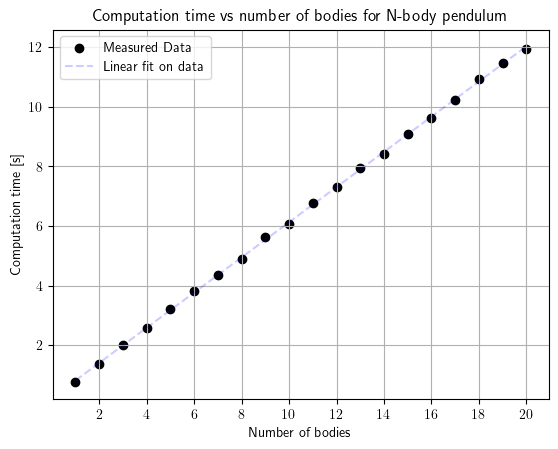

<Figure size 640x480 with 0 Axes>

In [8]:
#storing times from simulation above manually so i dont have to rerun

plt.rcParams['text.usetex'] = True

#fitting linear line
slope, intercept = np.polyfit(ns, times, 1)
fit_line = slope * ns + intercept


plt.scatter(ns,times,color="black",label="Measured Data")
plt.plot(ns,fit_line,"b--",alpha=0.2,label="Linear fit on data")
plt.grid()
plt.xlabel("Number of bodies")
plt.ylabel("Computation time [s]")
plt.title("Computation time vs number of bodies for N-body pendulum") 
plt.legend()
plt.xticks(ns[1::2])
specs_text = (
    "Simulation Specs:\n"
    "CPU: AMD Ryzen 5 2500U @ 2.0GHz | RAM: 8GB DDR4\n"
    "OS: Linux Mint 22.3 | Python 3.12.3 | Numpy 2.4.2"
)

#plt.figtext(0.5, 0.01, specs_text, ha="center", fontsize=8, 
            #bbox={"facecolor":"blue", "alpha":0.1, "pad":5})

#plt.subplots_adjust(bottom=0.2)


plt.show() 

plt.savefig("non_scipy_n_body.pdf", format="pdf")

In [32]:
#setting up link
n = 1
m = 200
l_hinge = np.array([0,0,0.5])
link = SOA.SimpleLink(m, l_hinge)
link.set_hingemap("spherical")


result,tspan,V_values = N_body_pendulum(n)

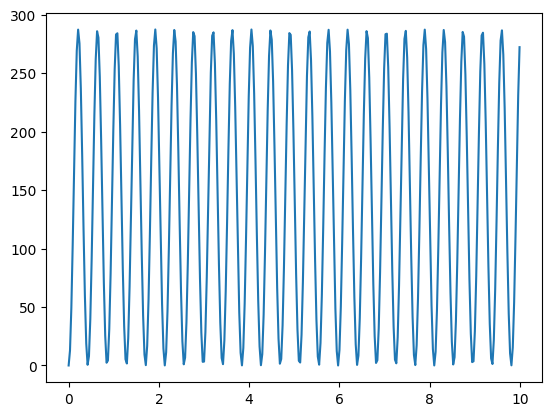

In [34]:
timesteps = len(tspan)
KE = np.zeros(timesteps)

for i in range(timesteps):
    KE_t = 0.0
    for k in range(1,n+1):
        Vk = V_values[i][k]
        KE_link = Vk @ link.M @ Vk
        KE_t += 0.5*KE_link
    KE[i] = KE_t

plt.plot(tspan,KE)
plt.show()

# Tidskompleksitet med solve_ivp

In [7]:
def N_body_pendulum_scipy(n):
    #setting up link
    m = 200
    l_hinge = np.array([0,0,0.5])
    link = SOA.SimpleLink(m, l_hinge)
    link.set_hingemap("spherical")

    #RBT is constant
    RBT = SOA.RBT(l_hinge)


    #initial config
    state0 = initial_config(n)

    def odefun(t, state, n, link,RBT):
        #solve_ivp passes state as np.array. It is unpacked, and then passed to ATBI as a a list of form state = [theta,beta].

        #unpacking state
        theta = state[:4*n]
        beta = state[4*n:]

        #normalizing quartenions
        SOA.normalize_quaternions(theta)
        
        #calculating theta_dot based on the derrivmap function
        theta_dot = np.zeros(len(theta))
        for i in range(n):
            idxq = 4*i #these indexes assume that we ONLY have spherical joints
            idxw = 3*i
            theta_dot[idxq:idxq+4] = SOA.derrivmap(theta[idxq:idxq+4],beta[idxw:idxw+3],"spherical")
            
        #Calculationg of generalized accelerations (beta_dot) - this requires ATBI. 
        tau_vec = np.zeros_like(beta) #no external torques

        A, V, beta_dot_list = ATBIalg(state, tau_vec, n, link, RBT)


        beta_dot = np.concatenate([b.flatten() for b in beta_dot_list[1:n+1]])

        state_dot = np.concatenate([theta_dot, beta_dot.flatten()])

        return state_dot

    def ATBIalg(state, tau_vec, n, link, RBT):

        #unpacking state

        theta_vec = state[:4*n]
        beta_vec  = state[4*n:]

        theta = [None]*(n+2)
        beta  = [None]*(n+2)
        tau   = [None]*(n+2)

        # boundary conditions - det kan diskuteres om man behøver i begge ender for dem alle, det gør man vidst nok ikke
        theta[0]   = np.zeros(4)
        theta[n+1] = np.zeros(4)

        beta[0]    = np.zeros(3)
        beta[n+1]  = np.zeros(3)

        tau[0]     = np.zeros(3)
        tau[n+1]   = np.zeros(3)

        #unpacking interior (IDK OM VI SKAL PASSE DOM EN FUCKING LISTE JEG FØLGER MIT RETARD MATLAB)
        for i in range(1, n+1):

            idxq = 4*(i-1)
            idxw = 3*(i-1)

            theta[i] = theta_vec[idxq:idxq+4]
            beta[i]  = beta_vec[idxw:idxw+3]
            tau[i]   = tau_vec[3*(i-1):3*i]

        # Introducing damping (link closest to ground):
        #tau[n] = -1*beta[n]

        #storage
        P_plus = [None]*(n+2)
        xi_plus = [None]*(n+2)
        nu = [None]*(n+2)
        A = [None]*(n+2)
        V = [None]*(n+2)
        G = [None]*(n+2)
        beta_dot = [None]*(n+2)
        tau_bar = [None]*(n+2)
        agothic = [None]*(n+2)
        bgothic = [None]*(n+2)
        
        #gravity and storage of gravity
        g = [None]*(n+2)
        g[n+1] = np.array([0,0,0,0,0,0*9.81])
        g_f = [None]*(n+2)
        g_f[n+1] = np.array([0,0,0,0,0,-9.81]) #to implement as force

        #boundary conditions on spatial operator quantities
        P_plus[0] = np.zeros((6,6))
        xi_plus[0] = np.zeros((6,))
        tau_bar[0] = P_plus[0]
        A[n+1] = np.array([0, 0, 0, 0, 0, 0])
        V[n+1] = np.zeros((6,))

        #kinematics scatter

        for k in range(n,0,-1):
            #rotation matrices
            pRc = SOA.spatialrotfromquat(theta[k]) #vurder det her
            cRp = pRc.T #from parent to child -> this is the direction we are going right now

            #rotating gravity such that we have that in frame aswell
            g[k] = cRp@g[k+1]
            g_f[k] = cRp@g_f[k+1]

            #hinge contribtuion
            delta_V = link.H.T @ beta[k]

            #spatial velocity
            V[k] = cRp @ RBT.T @ V[k+1] + delta_V

            #coriolois acc
            agothic[k] = SOA.spatialskewtilde(V[k]) @ link.H.T @ beta[k]

            #gyroscopic term
            bgothic[k] = SOA.spatialskewbar(V[k]) @ link.M @ V[k]

        #ATBI gather KOM I GANG
        for k in range(1,n+1): #n+1 fordi den ikke medtager n+1. Det så mærkeligt.

            #rotations
            pRc = SOA.spatialrotfromquat(theta[k-1])
            cRp = pRc.T 

            #gravity force
            f_g = link.M@g_f[k]

            P = RBT @ pRc @ P_plus[k-1] @ cRp@RBT.T + link.M
            D = link.H @ P @ link.H.T
            G[k] = np.linalg.solve(D, link.H @ P).T #P @ link.H.T @ np.linalg.inv(D)
            tau_bar[k] = np.eye(6) - G[k] @ link.H
            P_plus[k] = tau_bar[k] @ P
            xi = RBT @ pRc @ xi_plus[k-1] + P @ agothic[k] + bgothic[k] - SOA.RBT(link.l_com)@f_g
            eps = tau[k] - link.H@xi
            nu[k] = np.linalg.solve(D, eps) #= np.linalg.inv(D)@eps
            xi_plus[k] = xi + G[k]@eps

        #ATBI scatter
        for k in range(n,0,-1):
            #rotations
            pRc = SOA.spatialrotfromquat(theta[k])
            cRp = pRc.T 

            A_plus = cRp@ RBT.T @A[k+1]
            nu_bar = nu[k] - G[k].T @ g[k]  
            beta_dot[k] = nu_bar - G[k].T @ A_plus
            A[k] = A_plus + link.H.T @ beta_dot[k] + agothic[k]

        return A,V,beta_dot

    # Solve the ODE using scipy's solve_ivp
    tspan = np.arange(0, 30,0.03)
    result = solve_ivp(
        odefun, 
        t_span=(0, tspan[-1]), 
        y0=state0, 
        method='RK45',
        t_eval = tspan,
        args=(n,link,RBT)
        )
            # Extract time and state vectors
    return result, tspan


def initial_config(n):
    # Calculate initial config for n bodies
    # q0: All aligned and tilted to some side
    qn = SOA.quatfromrev(3*np.pi/4, "y")
    q_rest = np.array([0,0,0,1])
    q_rest_tiled = np.tile(q_rest, n-1)
    
    # Create the zero vectors for the other initial velocities states (n, 3)
    zeros = np.zeros(3 * n)
    
    # Concatenate into one long state vector
    state0 = np.concatenate([q_rest_tiled, qn, zeros])

    return state0

In [ ]:
ns = np.arange(1,21,1) #n0 = 1,2 .. 10 osv

times_scipy = []

for n in ns:
    print(f"Running simulation for n={n}...")
    start = time.perf_counter()
    result,tspan = N_body_pendulum_scipy(n)
    end = time.perf_counter()
    elapsed = end - start
    times_scipy.append(elapsed)

times_scipy = np.array(times)



Running simulation for n=1...
Running simulation for n=2...
Running simulation for n=3...
Running simulation for n=4...
Running simulation for n=5...
Running simulation for n=6...
Running simulation for n=7...
Running simulation for n=8...
Running simulation for n=9...
Running simulation for n=10...
Running simulation for n=11...
Running simulation for n=12...
Running simulation for n=13...
Running simulation for n=14...
Running simulation for n=15...
Running simulation for n=16...
Running simulation for n=17...
Running simulation for n=18...
Running simulation for n=19...
Running simulation for n=20...


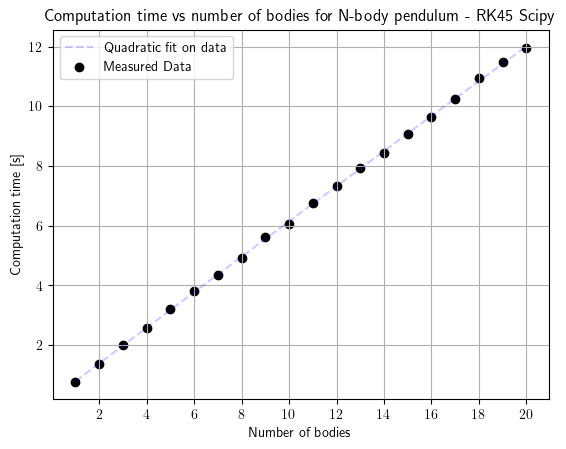

In [ ]:

plt.rcParams['text.usetex'] = True

#fitting linear line
a, b,c = np.polyfit(ns, times_scipy, 2)
fit_line = a* ns**2 + b*ns + c


plt.plot(ns,fit_line,"b--",alpha=0.2,label="Quadratic fit on data")
plt.scatter(ns,times_scipy,color="black",label="Measured Data")
plt.grid()
plt.xlabel("Number of bodies")
plt.ylabel("Computation time [s]")
plt.title("Computation time vs number of bodies for N-body pendulum - RK45 Scipy") 
plt.legend()
plt.xticks(ns[1::2])

# specs_text = (
#     "Simulation Specs:\n"
#     "CPU: AMD Ryzen 5 2500U @ 2.0GHz | RAM: 8GB DDR4\n"
#     "OS: Linux Mint 22.3 | Python 3.12.3 | Numpy 2.4.2"
# )

#plt.figtext(0.5, 0.01, specs_text, ha="center", fontsize=8, 
            #bbox={"facecolor":"blue", "alpha":0.1, "pad":5})

#plt.subplots_adjust(bottom=0.2)

plt.savefig("scipy_n_body.pdf", format="pdf")
plt.show() 